## Import statements

In [2]:
from Scripte.korpus import Korpus
from Scripte.settings import Settings

import json
import re
import string
import spacy

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

from tqdm.notebook import tqdm
from functools import reduce
from pathlib import Path
from datetime import datetime
from collections import Counter

from spacy.lang.de import German

In [3]:
nlp = spacy.load('de_core_news_lg')# oder md  oder lg  wenn heruntergeladen

## Functions

In [4]:
def _convert_text(text:str) -> str:
    replacements = [(r"http.+?\s", " "), (r"([a-z])([A-Z])", r"\1 \2"), (r"", ""), 
                    (r"", ""), (r"\*{2,}", ""), ("_+", ""), ]
    for old, new in reversed(replacements):
        text = text.replace(old, new)
    return _convert_entities(text)

def _convert_entities(text:str) -> str:
    doc = nlp(text)
    for entity in reversed(doc.ents):
        text = text[:entity.start_char] + entity.label_ + text[entity.end_char:]
    return text
    

def _convert_wordcount(number: str) -> int:
    return int(number.replace(".", ""))

def _convert_release(date:str):
    return datetime.strptime(date.strip(), "%d.%m.%Y")
 
def old_create_df(path, gender):
    data = reduce(lambda a, b: a.append(b, ignore_index= True), tqdm([create_part(x) for x in path]))
    data["gender"] = gender
    return data

def create_df(path, gender, genre):
    data = pd.concat([create_part(x) for x in tqdm(path)], ignore_index=True)
    data["gender"] = gender
    data["genre"] = genre
    return data

def contains_words(string : str, words) -> bool:
    return any(x in string for x in words)

def create_part(file) -> pd.DataFrame:
    start = json.load(open(file))
    x = pd.DataFrame.from_dict(start["chapters"], orient= "index", columns=["text", "wordcount"])
    x["text"] = x["text"].apply(_convert_text)
    x["wordcount"] = x["wordcount"].apply(_convert_wordcount)
    x["novel"] = re.sub(r"\W", " ", start["title"])
    x["release"] = _convert_release(start["release"])
    return x 
    

### Korpus aufbauen

In [5]:
#krimis
krimi_W = [x for x in Path("./jsondata/krimis/W").glob('**/*') if x.is_file() if x.suffix == ".json"]
krimi_M = [x for x in Path("./jsondata/krimis/M").glob('**/*') if x.is_file() if x.suffix == ".json"]
#horror
hor_W= [x for x in Path("./jsondata/horror/W").glob('**/*') if x.is_file() if x.suffix == ".json"]
hor_M= [x for x in Path("./jsondata/horror/M").glob('**/*') if x.is_file() if x.suffix == ".json"]
#abenteuer 
aben_W= [x for x in Path("./jsondata/abenteuer/W").glob('**/*') if x.is_file() if x.suffix == ".json"]
aben_M= [x for x in Path("./jsondata/abenteuer/M").glob('**/*') if x.is_file() if x.suffix == ".json"]

#combined
json_M = krimi_M + hor_M + aben_M
json_W = krimi_W + hor_W + aben_W

### Diese Schritte brauchen eine Weile. Wenn ihr sie einmal durch habt, könnt ihr unten CSV save/ load verwenden 

In [6]:
data_krimi_M = create_df(krimi_M,"M", "krimi")
data_krimi_W = create_df(krimi_W,"W","krimi")

In [7]:
data_hor_M = create_df(hor_M, "M", "horror")
data_hor_W = create_df(hor_W,"W","horror")

In [8]:
data_aben_M = create_df(aben_M, "M", "abenteuer")
data_aben_W = create_df(aben_W,"W","abenteuer")

In [9]:
data_krimi_full = pd.concat([data_krimi_M, data_krimi_W],ignore_index=True)
data_aben_full = pd.concat([data_aben_M, data_aben_W],ignore_index=True)
data_hor_full = pd.concat([data_hor_M, data_hor_W],ignore_index=True)

## Summen der Wörter

## load and save from csv


In [10]:
data_krimi_full.to_csv("csv_data_krimi_full.csv", sep ="|")
data_aben_full.to_csv("csv_data_aben_full.csv", sep="|")
data_hor_full.to_csv("csv_data_hor_full.csv",sep="|")

In [11]:
data_krimi_full= pd.read_csv("csv_data_krimi_full.csv", sep ="|")
data_aben_full= pd.read_csv("csv_data_aben_full.csv", sep="|")
data_hor_full = pd.read_csv("csv_data_hor_full.csv",sep="|")

## build from csv files all permutations

In [12]:
data_krimi_M = data_krimi_full.loc[data_krimi_full["gender"] == "M"]
data_krimi_W = data_krimi_full.loc[data_krimi_full["gender"] == "W"]
data_aben_M = data_aben_full.loc[data_aben_full["gender"] == "M"]
data_aben_W = data_aben_full.loc[data_aben_full["gender"] == "W"]
data_hor_M = data_hor_full.loc[data_hor_full["gender"] == "M"]
data_hor_W = data_hor_full.loc[data_hor_full["gender"] == "W"]

# full gender views

data_all_M = pd.concat([data_krimi_M, data_aben_M, data_hor_M], ignore_index=True)
data_all_W = pd.concat([data_krimi_W, data_hor_W, data_aben_W], ignore_index=True)

data_all = pd.concat([data_krimi_full, data_aben_full, data_hor_full], ignore_index=True)

# Analyse und Berechnung

## Vorbereitung

In [13]:
joined_text_krimi_M = data_krimi_M.groupby('novel')['text'].apply(' '.join)
joined_text_krimi_W = data_krimi_W.groupby('novel')['text'].apply(' '.join)
joined_text_krimi_full = pd.concat([joined_text_krimi_M,joined_text_krimi_W])

In [14]:
joined_text_aben_W = data_aben_W.groupby('novel')['text'].apply(' '.join)
joined_text_aben_M = data_aben_M.groupby('novel')['text'].apply(' '.join)
joined_text_aben_full = pd.concat([joined_text_aben_M, joined_text_aben_W])

joined_text_hor_W = data_hor_W.groupby('novel')['text'].apply(' '.join)
joined_text_hor_M = data_hor_M.groupby('novel')['text'].apply(' '.join)
joined_text_hor_full = data_hor_full.groupby('novel')["text"].apply(' '.join)

joined_text_M_full = pd.concat([joined_text_krimi_M,  joined_text_aben_M]) #joined_text_hor_M,
joined_text_W_full = pd.concat([joined_text_krimi_W,  joined_text_aben_W])#joined_text_hor_W,

In [15]:
joined_text_all = data_all.groupby('novel')['text'].apply(' '.join)


## Dieser Schritt braucht etwas!

In [16]:
brut_list = 'brutal schlagen schlug mord misshandeln vergewaltigen überfall tod töten tot treten tritt trat verfolgen hart extrem attacke angriff angreifen metzeln reißen missbrauch zerstören prügel rücksichtslos qual quälen blut griff gewalt tat härte diktator krieg schlacht anschlag schläge terror folter killer teulisch gemein brechen bombe sadistisch erbarmungslos barbarisch knochen verletzen roh grob kampf waffen messer knüppel stoßen lust sexuell diebstahl vandalismus amok belästigen mobbing brand demütigen erpressen nötigung rassismus sabotage stalker hass psychisch einschüchtern entführung beleidigen schimpfen schrei ohrenbetäubend betäubung drogen spritzen kämpfen boxen knöchel schlitzen brechen gedärme teufel dämon bestie schreck hexe kriminalität kriminell liste böse prositution schänden schand entblößen entstellen pervers mafia bosheit fleischwunde gebeine skelett gerippe meucheln umbringen auslöschen kannibale sterben pistole gewehr klinge cutter verbrecher dieb straftäter assassine vergehen entehren unterwerfen entmenscht genitalien faust attentat säge'

brut_final = [token.lemma_ for token in nlp(brut_list)]

def get_brut_ratio(series)-> pd.DataFrame:
    results = []
    for novel, text in series.items():
        if len(text)> nlp.max_length:
            for x in _get_results(novel,text):
                results.append(x)
                print(f"LOG: finished {novel}")
        else:
            results.append([novel]+calc_data(text))
            print(f"LOG: finished {novel}")
        #results.append([novel, brut_sum, brut_types, total_words, percentage])   
    df = pd.DataFrame(results, columns=['novel', 'brut_sum', 'brut_type', 'Total Words', 'Percentage'])

    return df

def _get_results(novel:str, text:str):
    results = []
    chunks = [text[i:i+nlp.max_length] for i in range(0, len(text), nlp.max_length)]
    for i, chunk in enumerate(chunks):
        str_ = f"{novel}_{i}"
        results.append([str_]+ calc_data(chunk))
    return results

def calc_data(text): 
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.lemma_ != "--"]
    count_part = Counter([lemma for lemma in lemmas if lemma in brut_final])
    brut_sum = sum(count_part.values())
    brut_types = len(count_part)
    total_words = len(lemmas)
    percentage = (brut_sum / total_words) * 100
                       
    return [brut_sum, brut_types, total_words, percentage]


# Dies hier wird weiter bearbeitet!

In [17]:
# Set max_length according to your PC, the higher, the more RAM is required 100000 ~~ 1 GB
nlp.max_length = 600000

# Choose those you want to view/compare/plot later, results in DFs
data_comp1_krimi = get_brut_ratio(joined_text_krimi_W)
data_comp1_krimi["field"] = "krimi_W"
data_comp2_krimi = get_brut_ratio(joined_text_krimi_M)
data_comp2_krimi["field"] = "krimi_M"


LOG: finished Albtraum
LOG: finished Alina
LOG: finished Aller Anfang ist schwer
LOG: finished Angel  Arbeitstitel 
LOG: finished Anonym
LOG: finished Auf den Spuren der Vergangenheit
LOG: finished Authorities Task Force
LOG: finished Being Jack
LOG: finished Broken Mirrors   
LOG: finished Bruderliebe
LOG: finished CRY
LOG: finished Cube
LOG: finished Das Attentat
LOG: finished Das Böse hat ein Herz
LOG: finished Das mörderische Krimidinner
LOG: finished Death Teacher
LOG: finished Der Anfang der Katastrophen oder London calling
LOG: finished Der Diamantenprinz
LOG: finished Der Fall Lukis
LOG: finished Der Herzensbrecher
LOG: finished Der Mountie   Das Geheimnis der toten Elche
LOG: finished Der Zweck heiligt die Mittel
LOG: finished Der erste Fall
LOG: finished Die Entführung
LOG: finished Die Fassade
LOG: finished Die Nacht im Mai
LOG: finished Die Stunde der Angst
LOG: finished Die weiße Witwe
LOG: finished Eiskalt
LOG: finished Emma
LOG: finished Falsche Sterne über Tokyo
LOG: fi

In [20]:
data_final_krimi = pd.concat([data_comp1_krimi, data_comp2_krimi])


In [21]:
data_final.to_csv("csv_analyse_data_krimi.csv", sep ="|")


NameError: name 'data_final' is not defined

In [23]:
data_final_aben = pd.read_csv("csv_analyse_data_aben.csv", sep ="|" )
data_final_aben

Unnamed: 0                         novel  brut_sum  brut_type  \
0             0                     A Way Out        93         30   
1             1            Afrika im Herzen_0       549         51   
2             2            Afrika im Herzen_1       370         41   
3             3                     Afterlife       132         21   
4             4                  Ai e no pasu       102         26   
..          ...                           ...       ...        ...   
158          44  Tokyo Devils  Tokyo Sharks_1       528         52   
159          45  Tokyo Devils  Tokyo Sharks_2       432         55   
160          46  Tokyo Devils  Tokyo Sharks_3        10          8   
161          47                     Ulrik 2_0       726         59   
162          48                     Ulrik 2_1       554         50   

     Total Words  Percentage   field  
0          12914    0.720149  aben_W  
1          97613    0.562425  aben_W  
2          66866    0.553345  aben_W  
3          13869    0.951763  aben_W  
4          13260    0.769231  aben_W  
..           ...         ...     ...  
158        97000    0.544330  aben_M  
159        97880    0.441357  aben_M  
160         4109    0.243368  aben_M  
161        97277    0.746322  aben_M  
162        66608    0.831732  aben_M  

[163 rows x 7 columns]

In [24]:
data_final_hor = pd.read_csv("csv_analyse_data_hor.csv", sep ="|" )
data_final_hor

Unnamed: 0                                              novel  brut_sum  \
0             0                                         43 Stunden        81   
1             1                                    7 Tage Wahnsinn       136   
2             2                                    Aloha From Hell       150   
3             3                                  Am Ende des Tages       148   
4             4                                     Amusement Park       122   
..          ...                                                ...       ...   
108          36  Its hard to survive___Eine Zombie Apokalypse M...       393   
109          37                                     Justitia Games       114   
110          38                                     Klassentreffen        48   
111          39                                     Kuss der Nacht        28   
112          40                                         Let s play       175   

     brut_type  Total Words  Percentage  field  
0           25        13566    0.597081  hor_W  
1           31        12090    1.124897  hor_W  
2           33        19602    0.765228  hor_W  
3           29        13800    1.072464  hor_W  
4           24        18122    0.673215  hor_W  
..         ...          ...         ...    ...  
108         49        33041    1.189431  hor_M  
109         38        16642    0.685014  hor_M  
110         17        13121    0.365826  hor_M  
111         10         2786    1.005025  hor_M  
112         35        18416    0.950261  hor_M  

[113 rows x 7 columns]

In [25]:
data_final_krimi = pd.read_csv("csv_analyse_data_krimi.csv", sep ="|" )
data_final_krimi

Unnamed: 0                    novel  brut_sum  brut_type  Total Words  \
0             0                 Albtraum       144         23        19159   
1             1                    Alina        85         19        12850   
2             2  Aller Anfang ist schwer        72         29        14258   
3             3     Angel  Arbeitstitel         88         23        11685   
4             4                   Anonym        41         15        11066   
..          ...                      ...       ...        ...          ...   
117          27              Tote Helden       207         37        35750   
118          28       Tödliche Begegnung       233         36        31566   
119          29           Unter Verdacht       209         30        21994   
120          30                 Verraten       124         31        15481   
121          31               Wolkenkind       373         47        53530   

     Percentage    field  
0      0.751605  krimi_W  
1      0.661479  krimi_W  
2      0.504980  krimi_W  
3      0.753102  krimi_W  
4      0.370504  krimi_W  
..          ...      ...  
117    0.579021  krimi_M  
118    0.738136  krimi_M  
119    0.950259  krimi_M  
120    0.800982  krimi_M  
121    0.696806  krimi_M  

[122 rows x 7 columns]

In [26]:
data_final_full = pd.read_csv("csv_analyse_data_full.csv", sep ="|" )
data_final_full

Unnamed: 0                                              novel  brut_sum  \
0             0                             Der rote Regenschirm          56   
1             1          MMFF  Dare you  Dare you  Double Dare you       294   
2             2                                                  3       126   
3             3                                         43 Stunden        81   
4             4                                    7 Tage Wahnsinn       136   
..          ...                                                ...       ...   
488         117                                          Vogelfrei       231   
489         118                        Vom Fischer und seiner Frau       169   
490         119  Wendland Saga 19  Jh    Alexander von Wendland...       282   
491         120                                 Zu Kreuze getragen        94   
492         121                        chicago   rache auf umwegen       100   

     brut_type  Total Words  Percentage       field  
0           22         9718    0.576250    hor_full  
1           41        30382    0.967678    hor_full  
2           29        12010    1.049126    hor_full  
3           25        13566    0.597081    hor_full  
4           31        12090    1.124897    hor_full  
..         ...          ...         ...         ...  
488         35        32917    0.701765  krimi_full  
489         33        18527    0.912182  krimi_full  
490         48        35133    0.802664  krimi_full  
491         28        11403    0.824344  krimi_full  
492         31        15498    0.645245  krimi_full  

[493 rows x 7 columns]

## Plotting

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# to make sure to not lose data, plots can be saved, make sure you change filename if you use this option
SAVE_FILES = True

subdirectory = Path('plots')
subdirectory.mkdir(parents=True, exist_ok=True)
#FILENAME- CHANGE THIS
plot_name = 'bar_hor_full_brut_type.png'
file_path = subdirectory / plot_name

In [29]:
df_aben =  data_final_aben.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

# Viewing the Data

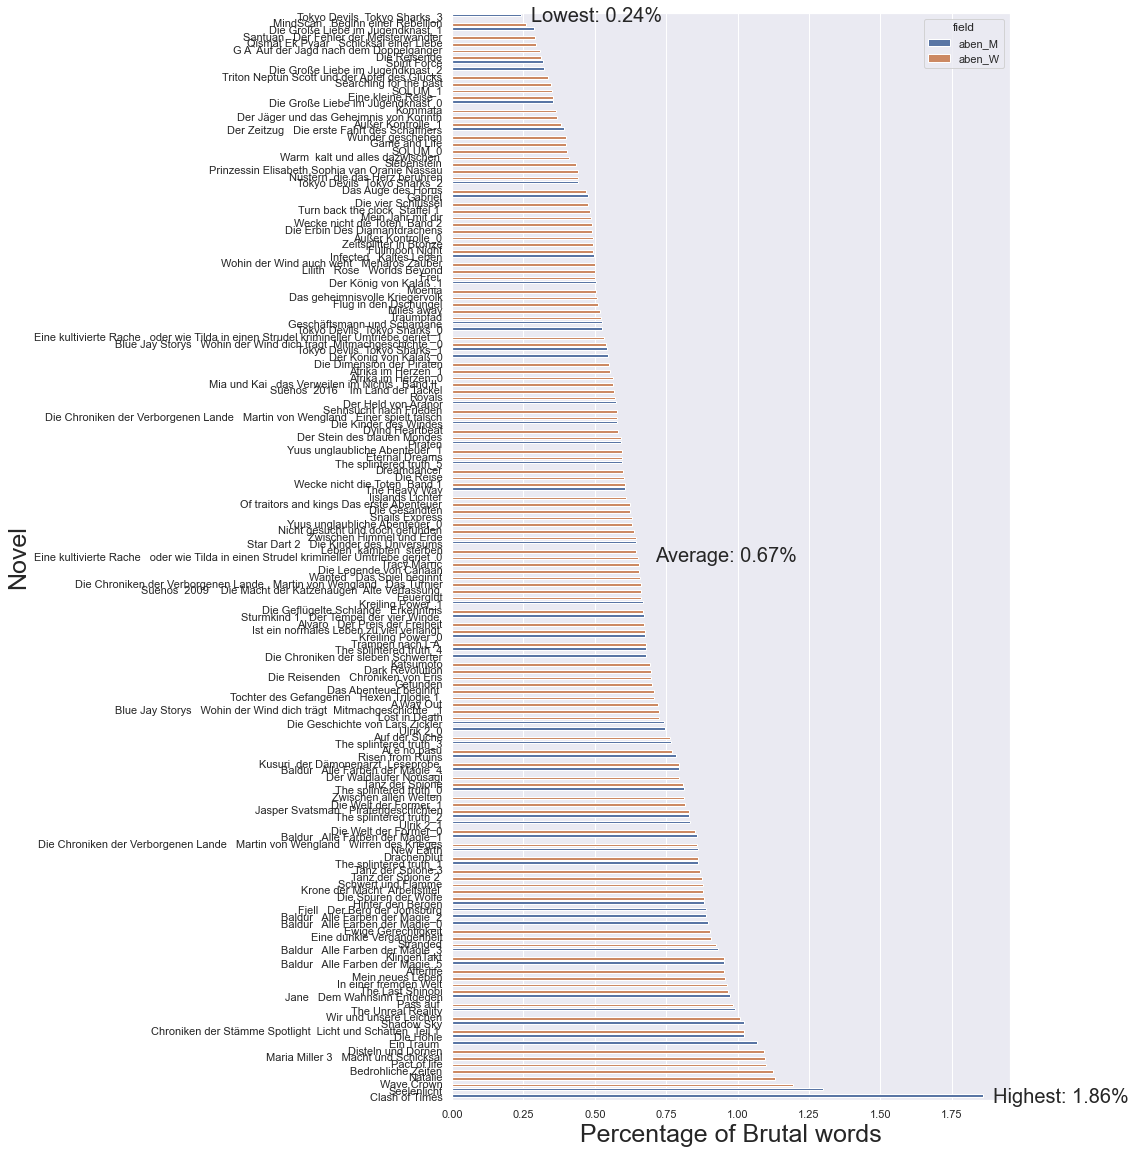

In [31]:
#Die Tabelle von aben
data_final_aben_M = pd.read_csv("csv_analyse_data_aben.csv", sep ="|" )
df_aben =  data_final_aben.sort_values('Percentage', ascending=True)

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', hue='field', data=df_aben)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_aben['Percentage'].max()
lowest_percentage = df_aben['Percentage'].min()
average_percentage = df_aben['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_aben)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_aben)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

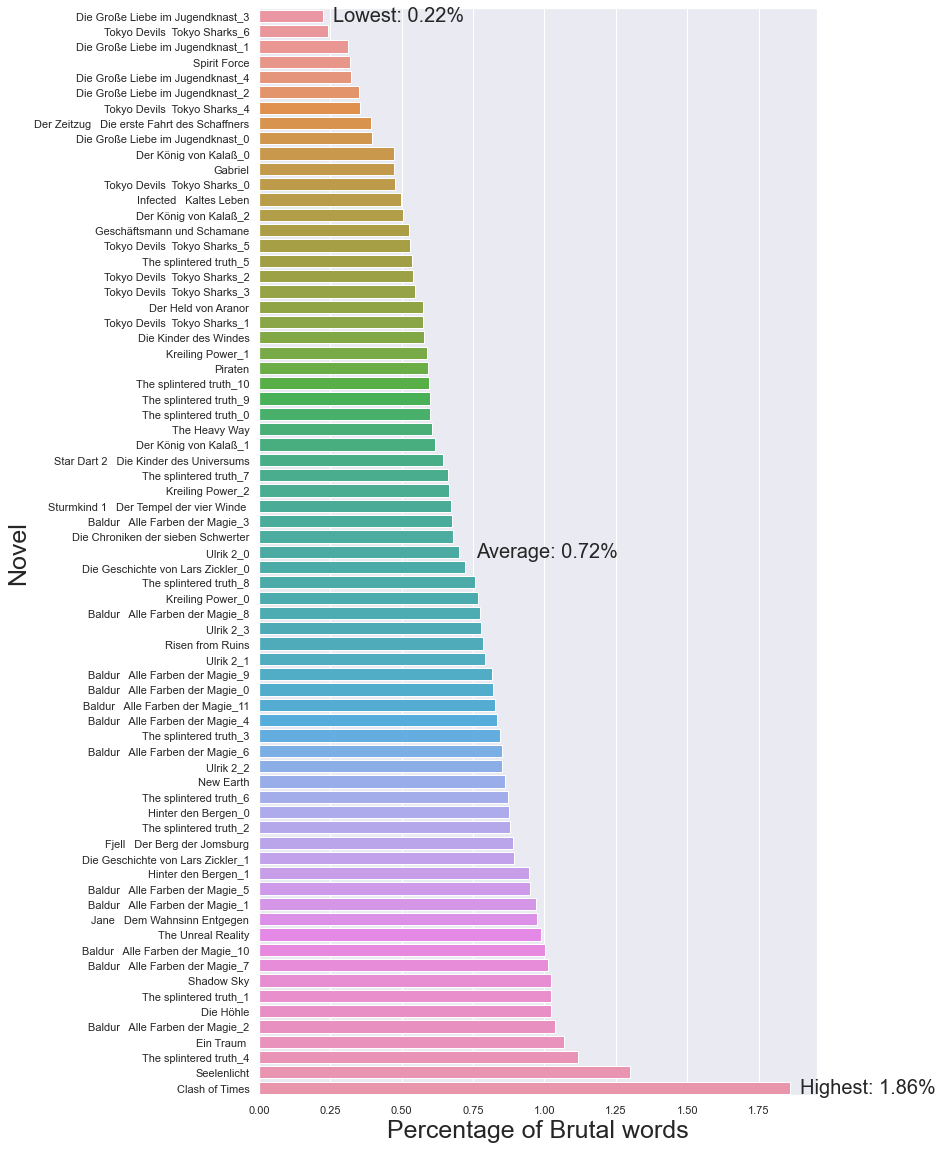

In [32]:
#Die Tabelle von aben_M
data_final_aben_M = pd.read_csv("finished_data_aben_M.csv", sep ="|" )
df_aben_M =  data_final_aben_M.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_aben_M)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_aben_M['Percentage'].max()
lowest_percentage = df_aben_M['Percentage'].min()
average_percentage = df_aben_M['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_aben_M)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_aben_M)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

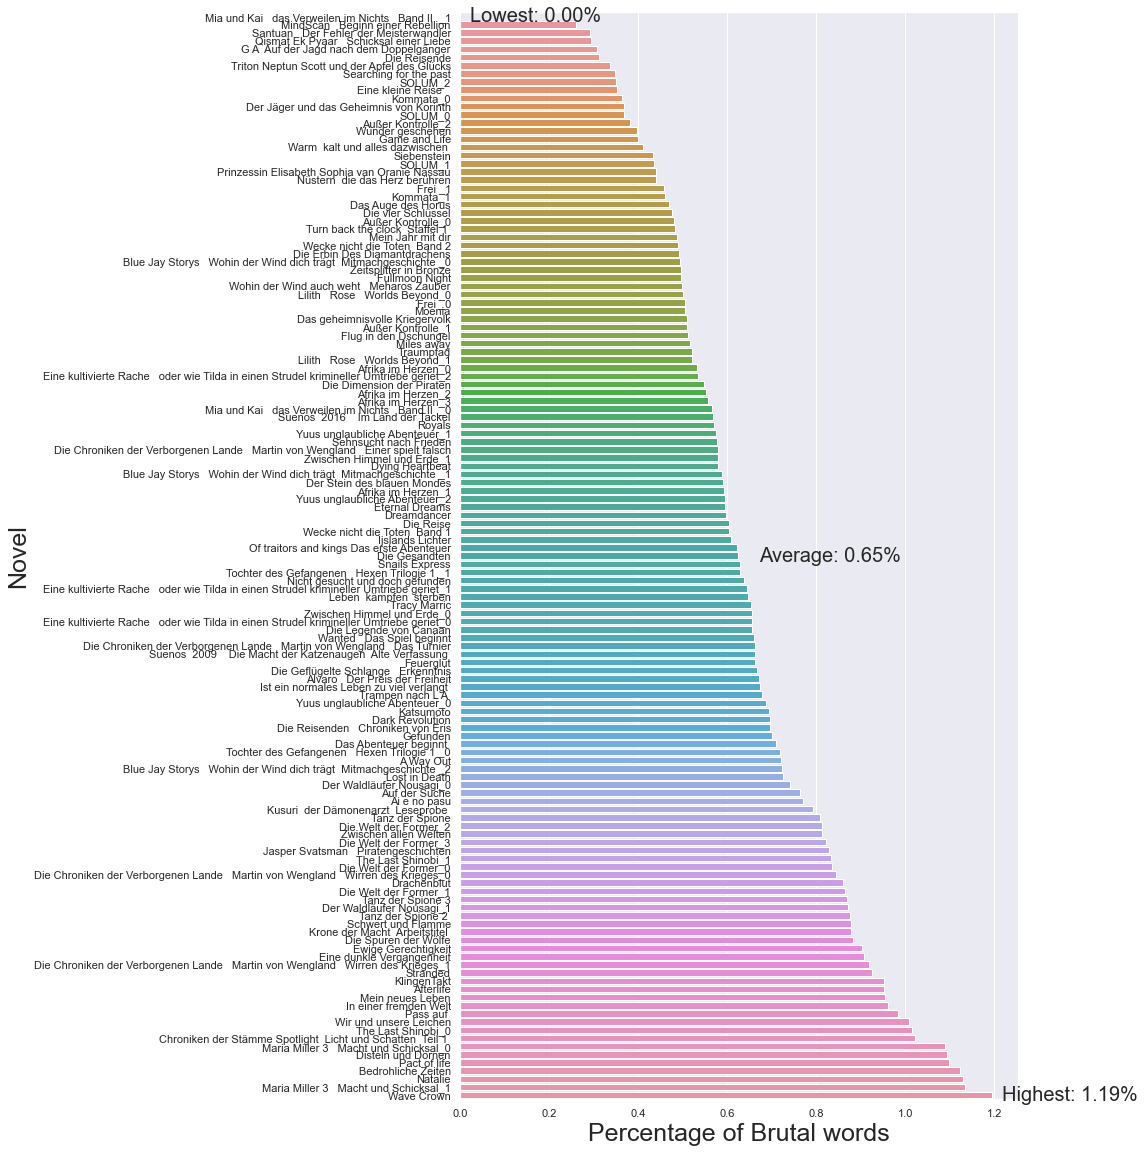

In [33]:
#Die Tabelle von aben_W
data_final_aben_W = pd.read_csv("finished_data_aben_W.csv", sep ="|" )
df_aben_W =  data_final_aben_W.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_aben_W)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_aben_W['Percentage'].max()
lowest_percentage = df_aben_W['Percentage'].min()
average_percentage = df_aben_W['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_aben_W)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_aben_W)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

In [34]:
#Die Tabelle von Krimi
df_krimi =  data_final_krimi.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

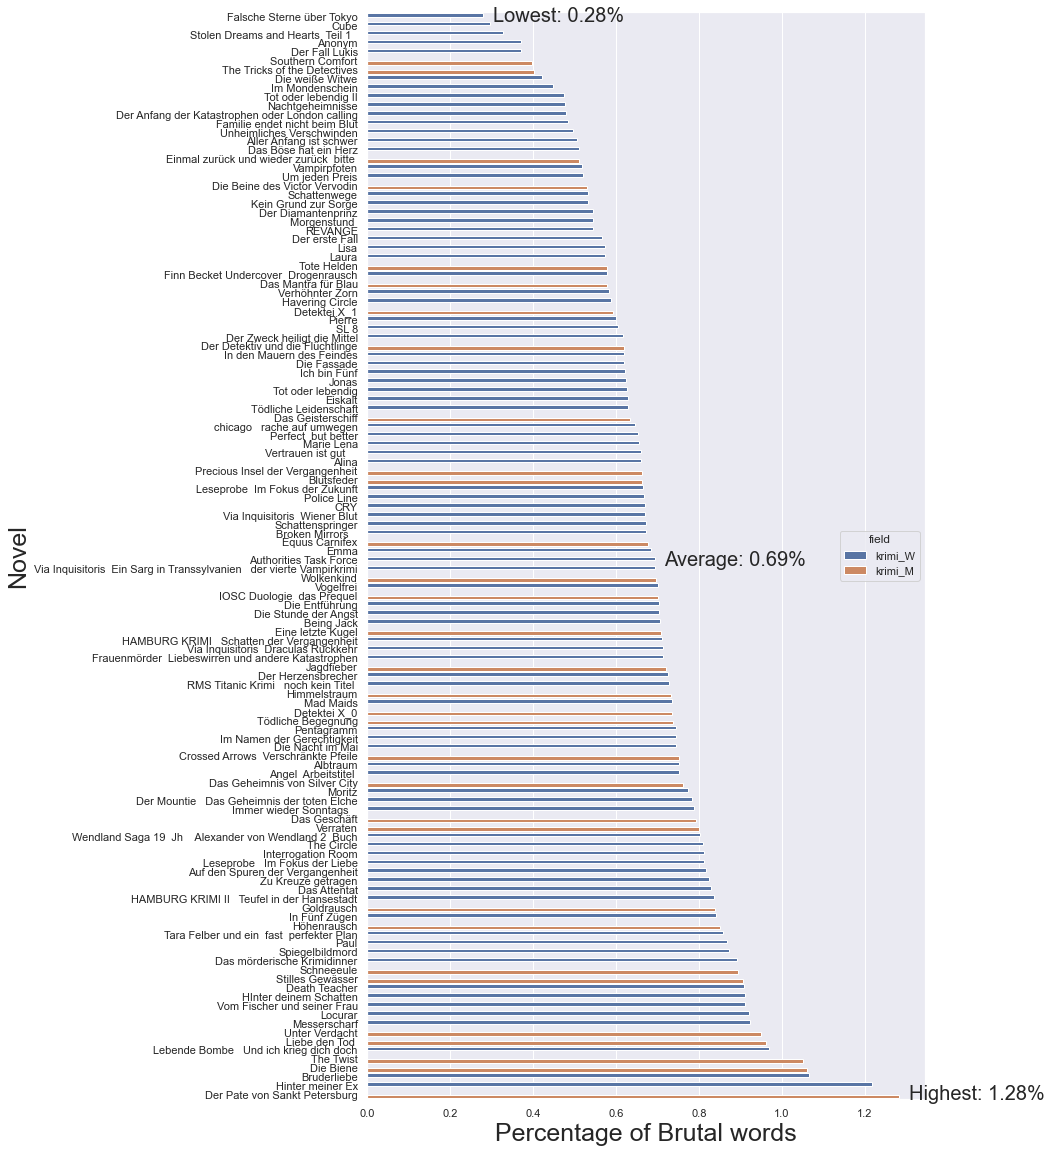

In [36]:
sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', hue='field', data=df_krimi)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_krimi['Percentage'].max()
lowest_percentage = df_krimi['Percentage'].min()
average_percentage = df_krimi['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_krimi)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_krimi)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

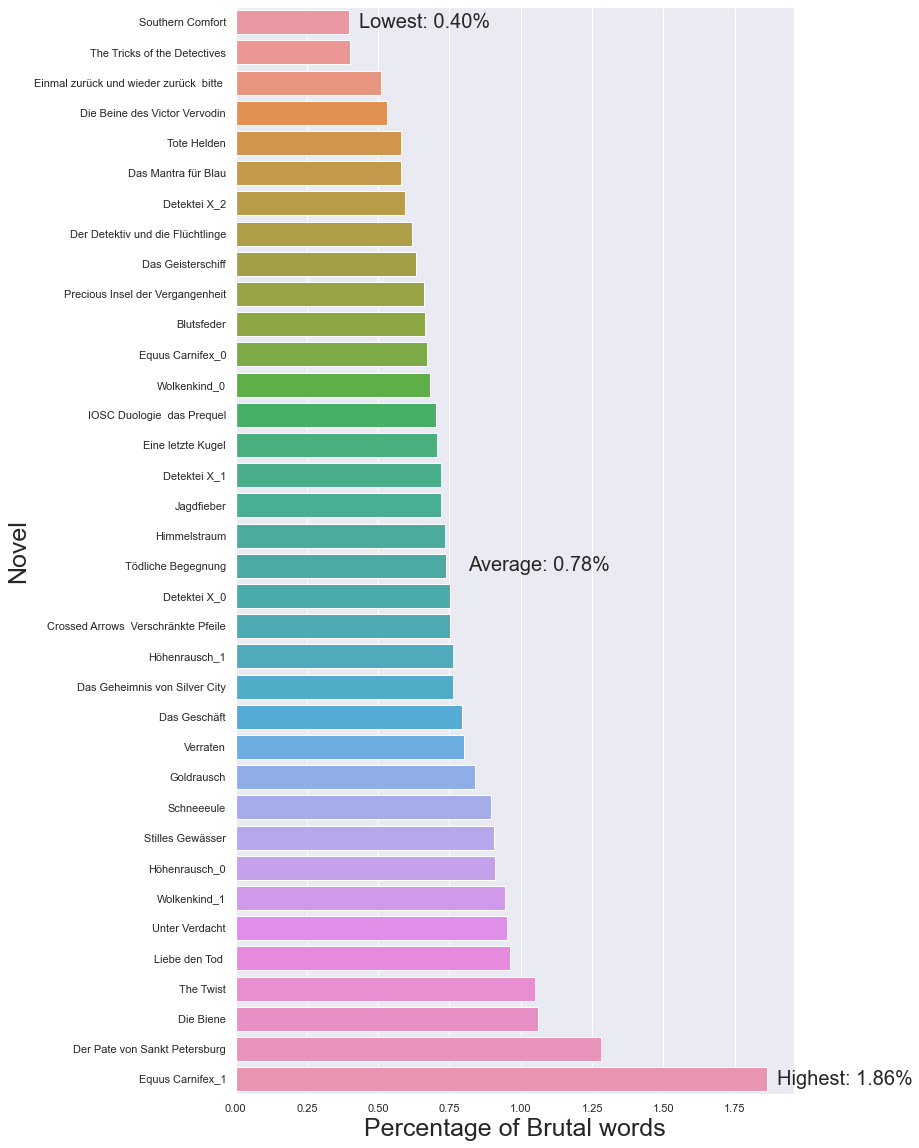

In [37]:
#Die Tabelle von Krimi_M
data_final_krimi_M = pd.read_csv("finished_data_krimi_M.csv", sep ="|" )
df_krimi_M =  data_final_krimi_M.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_krimi_M)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_krimi_M['Percentage'].max()
lowest_percentage = df_krimi_M['Percentage'].min()
average_percentage = df_krimi_M['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_krimi_M)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_krimi_M)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

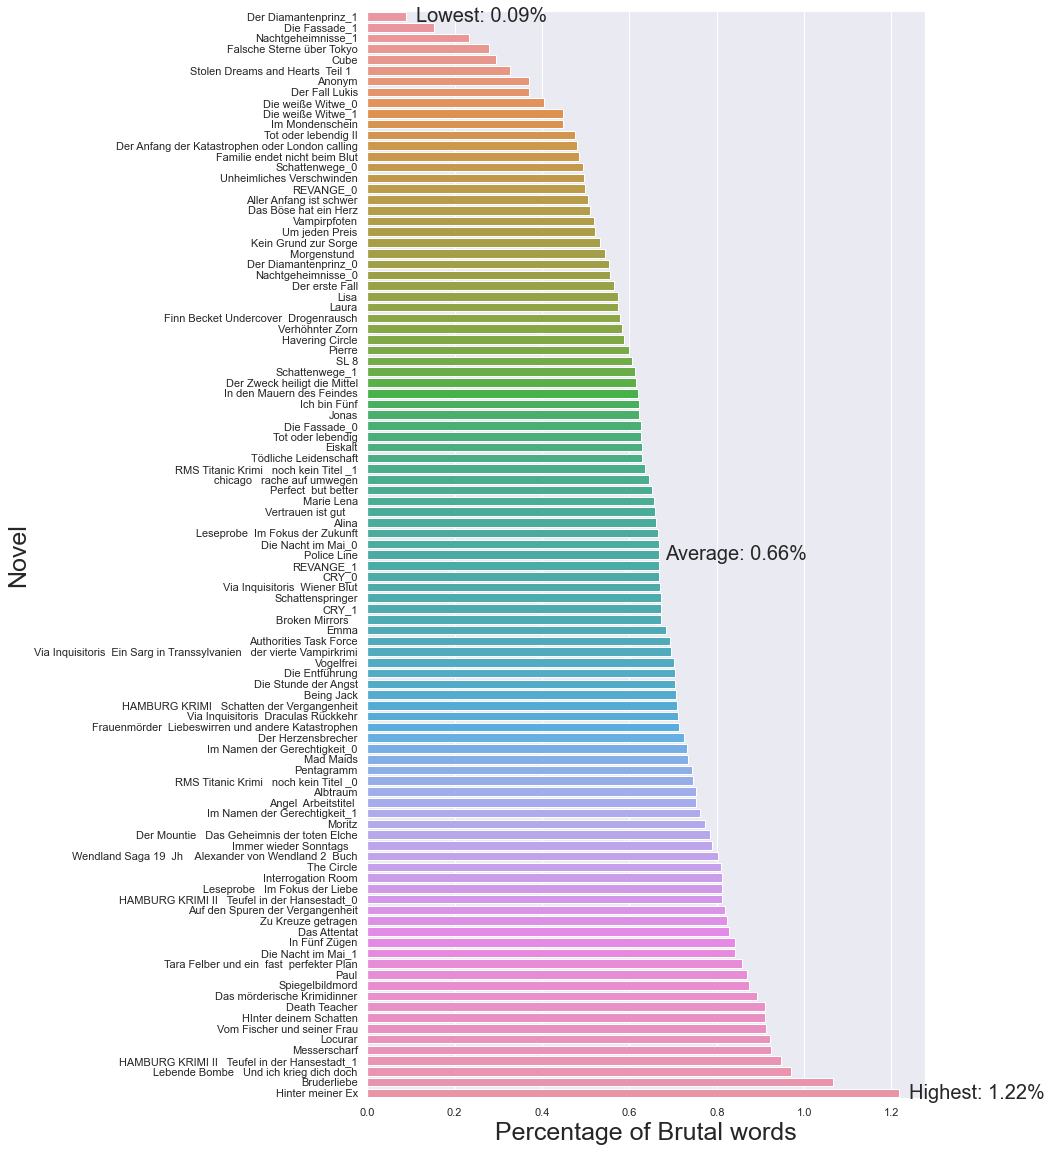

In [38]:
#Die Tabelle von Krimi_W
data_final_krimi_W = pd.read_csv("finished_data_krimi_W.csv", sep ="|" )
df_krimi_W =  data_final_krimi_W.sort_values('Percentage', ascending=True)
sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_krimi_W)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_krimi_W['Percentage'].max()
lowest_percentage = df_krimi_W['Percentage'].min()
average_percentage = df_krimi_W['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_krimi_W)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_krimi_W)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

In [39]:
#Die Tabelle von hor
df_hor =  data_final_hor.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

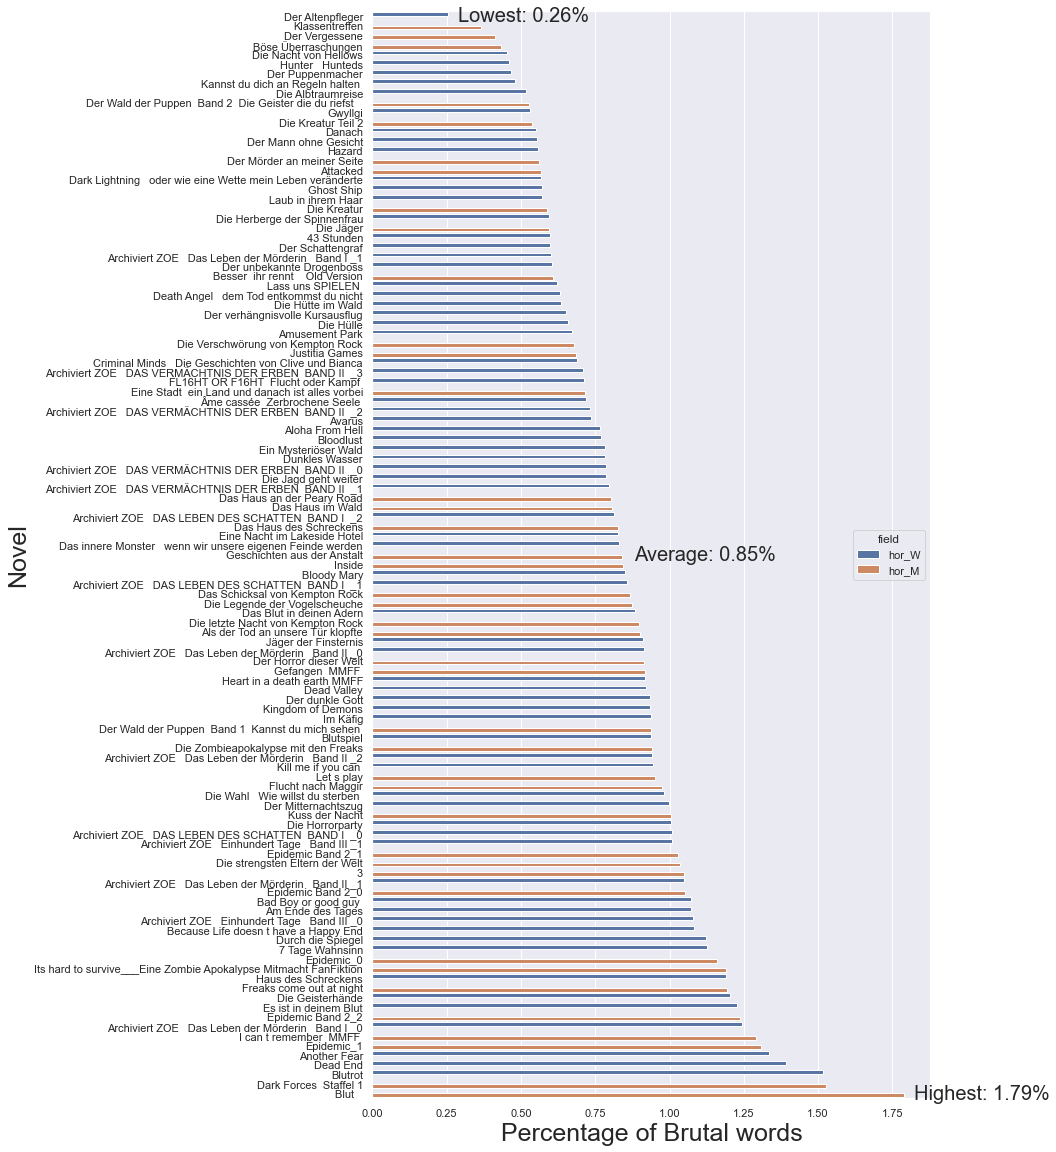

In [40]:
sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', hue='field', data=df_hor)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_hor['Percentage'].max()
lowest_percentage = df_hor['Percentage'].min()
average_percentage = df_hor['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_hor)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_hor)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

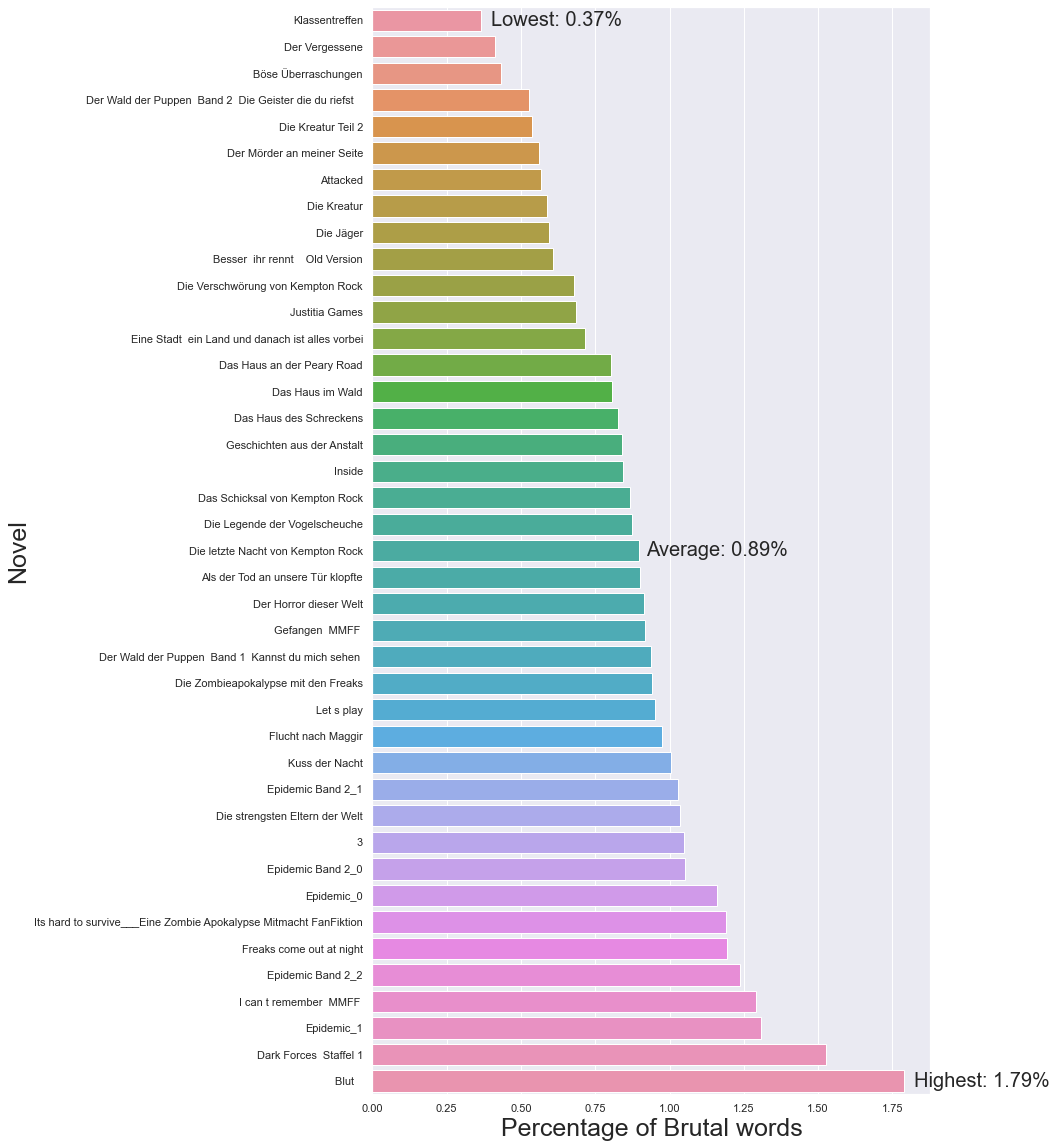

In [41]:
#Die Tabelle von hor_M
data_final_hor_M = pd.read_csv("finished_data_hor_M.csv", sep ="|" )
df_hor_M =  data_final_hor_M.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_hor_M)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_hor_M['Percentage'].max()
lowest_percentage = df_hor_M['Percentage'].min()
average_percentage = df_hor_M['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_hor_M)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_hor_M)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

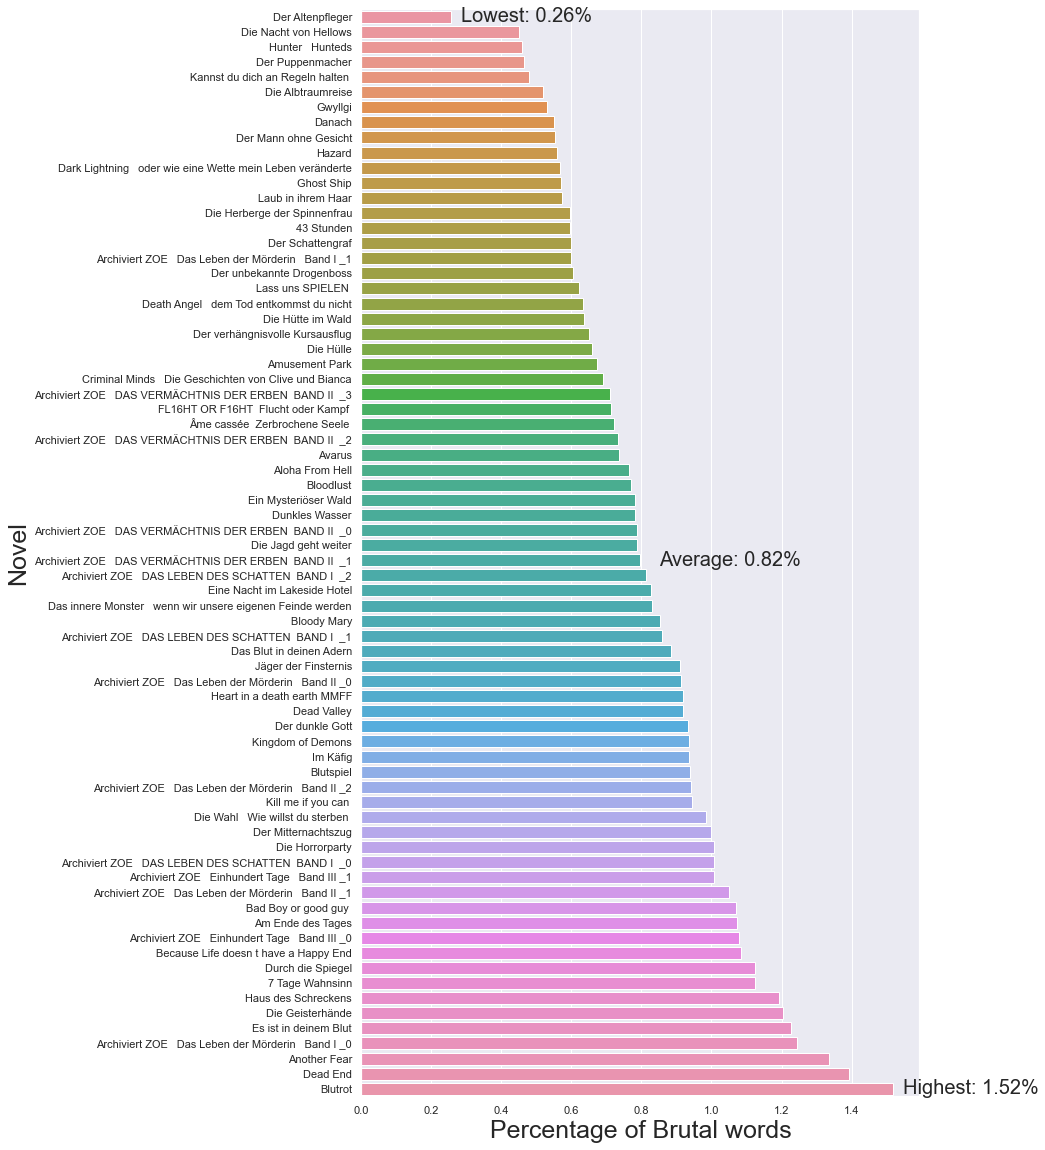

In [42]:
#Die Tabelle von hor_W
data_final_hor_W = pd.read_csv("finished_data_hor_W.csv", sep ="|" )
df_hor_W =  data_final_hor_W.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_hor_W)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_hor_W['Percentage'].max()
lowest_percentage = df_hor_W['Percentage'].min()
average_percentage = df_hor_W['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_hor_W)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_hor_W)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

In [43]:
#Die Tabelle von full
data_final_full = pd.read_csv("csv_analyse_data_full.csv", sep ="|" )
df_full =  data_final_full.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

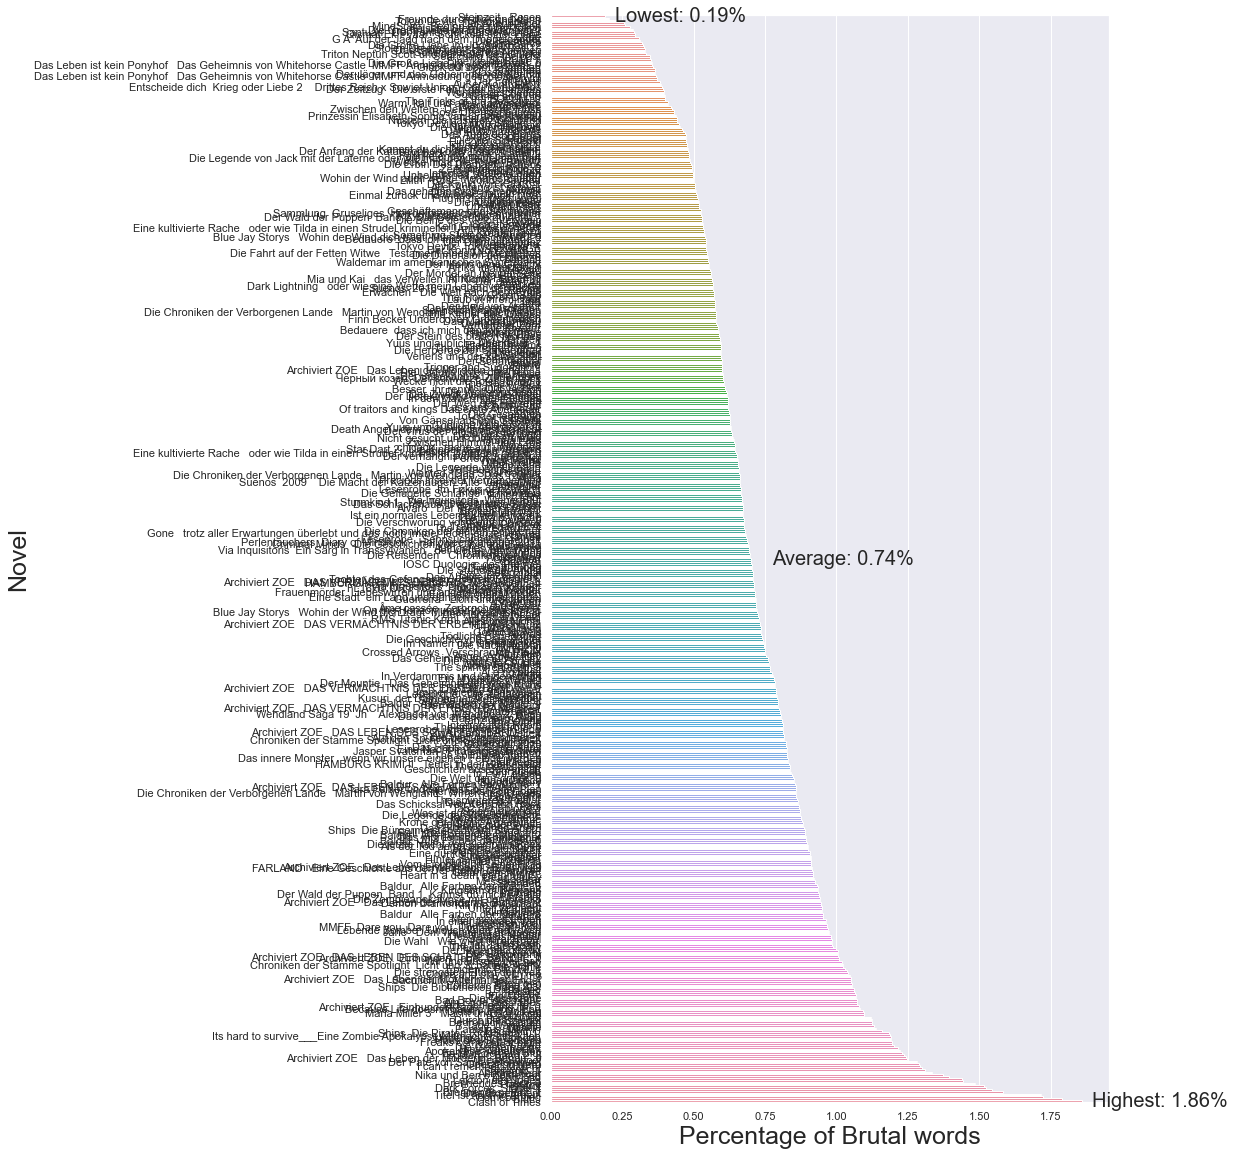

In [44]:
sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_full)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_full['Percentage'].max()
lowest_percentage = df_full['Percentage'].min()
average_percentage = df_full['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_full)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_full)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

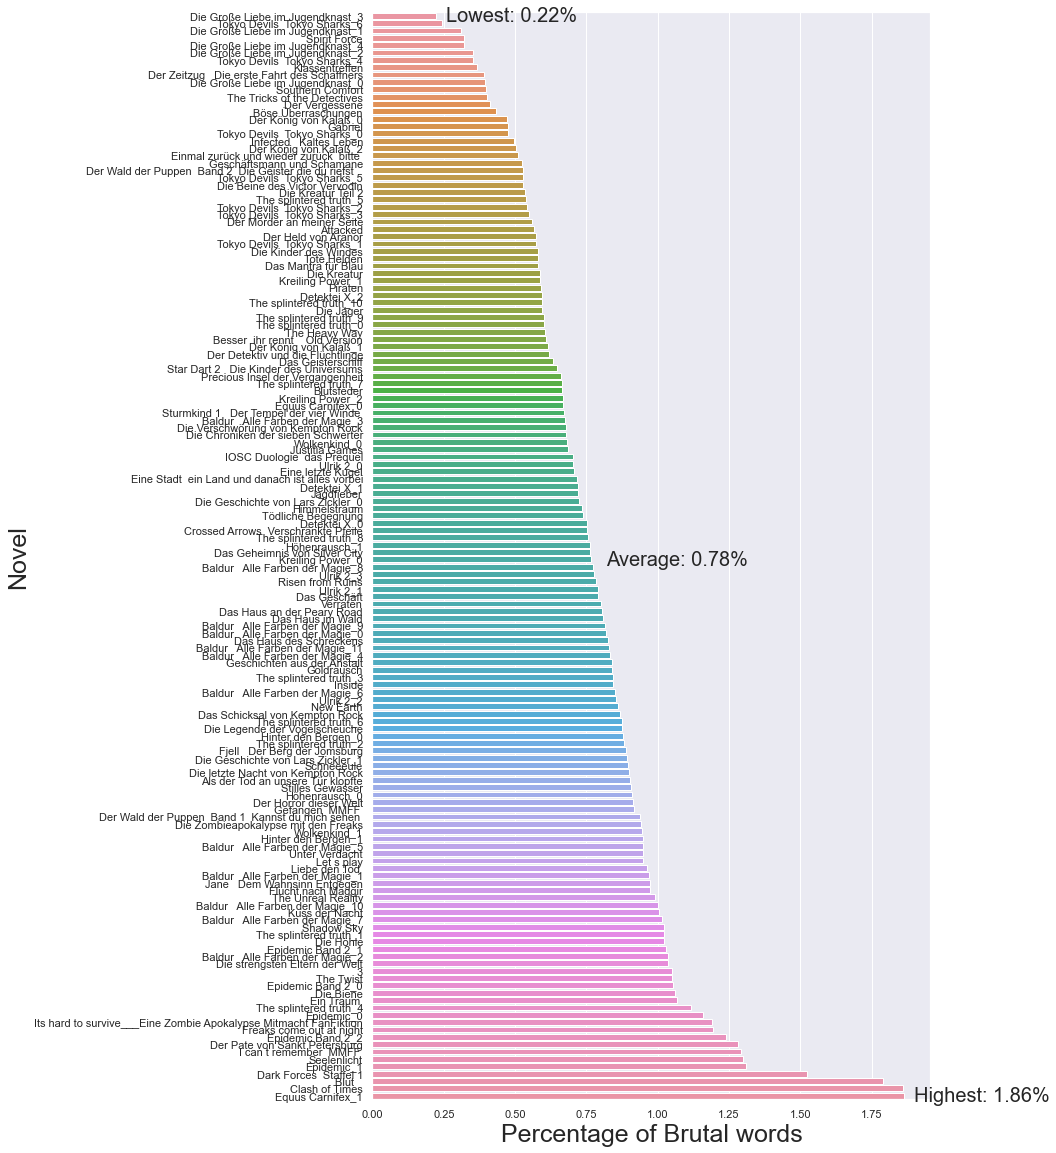

In [45]:
#Die Tabelle von full_M
data_final_full_M = pd.read_csv("finished_data_full_M.csv", sep ="|" )
df_full_M =  data_final_full_M.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_full_M)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_full_M['Percentage'].max()
lowest_percentage = df_full_M['Percentage'].min()
average_percentage = df_full_M['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_full_M)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_full_M)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

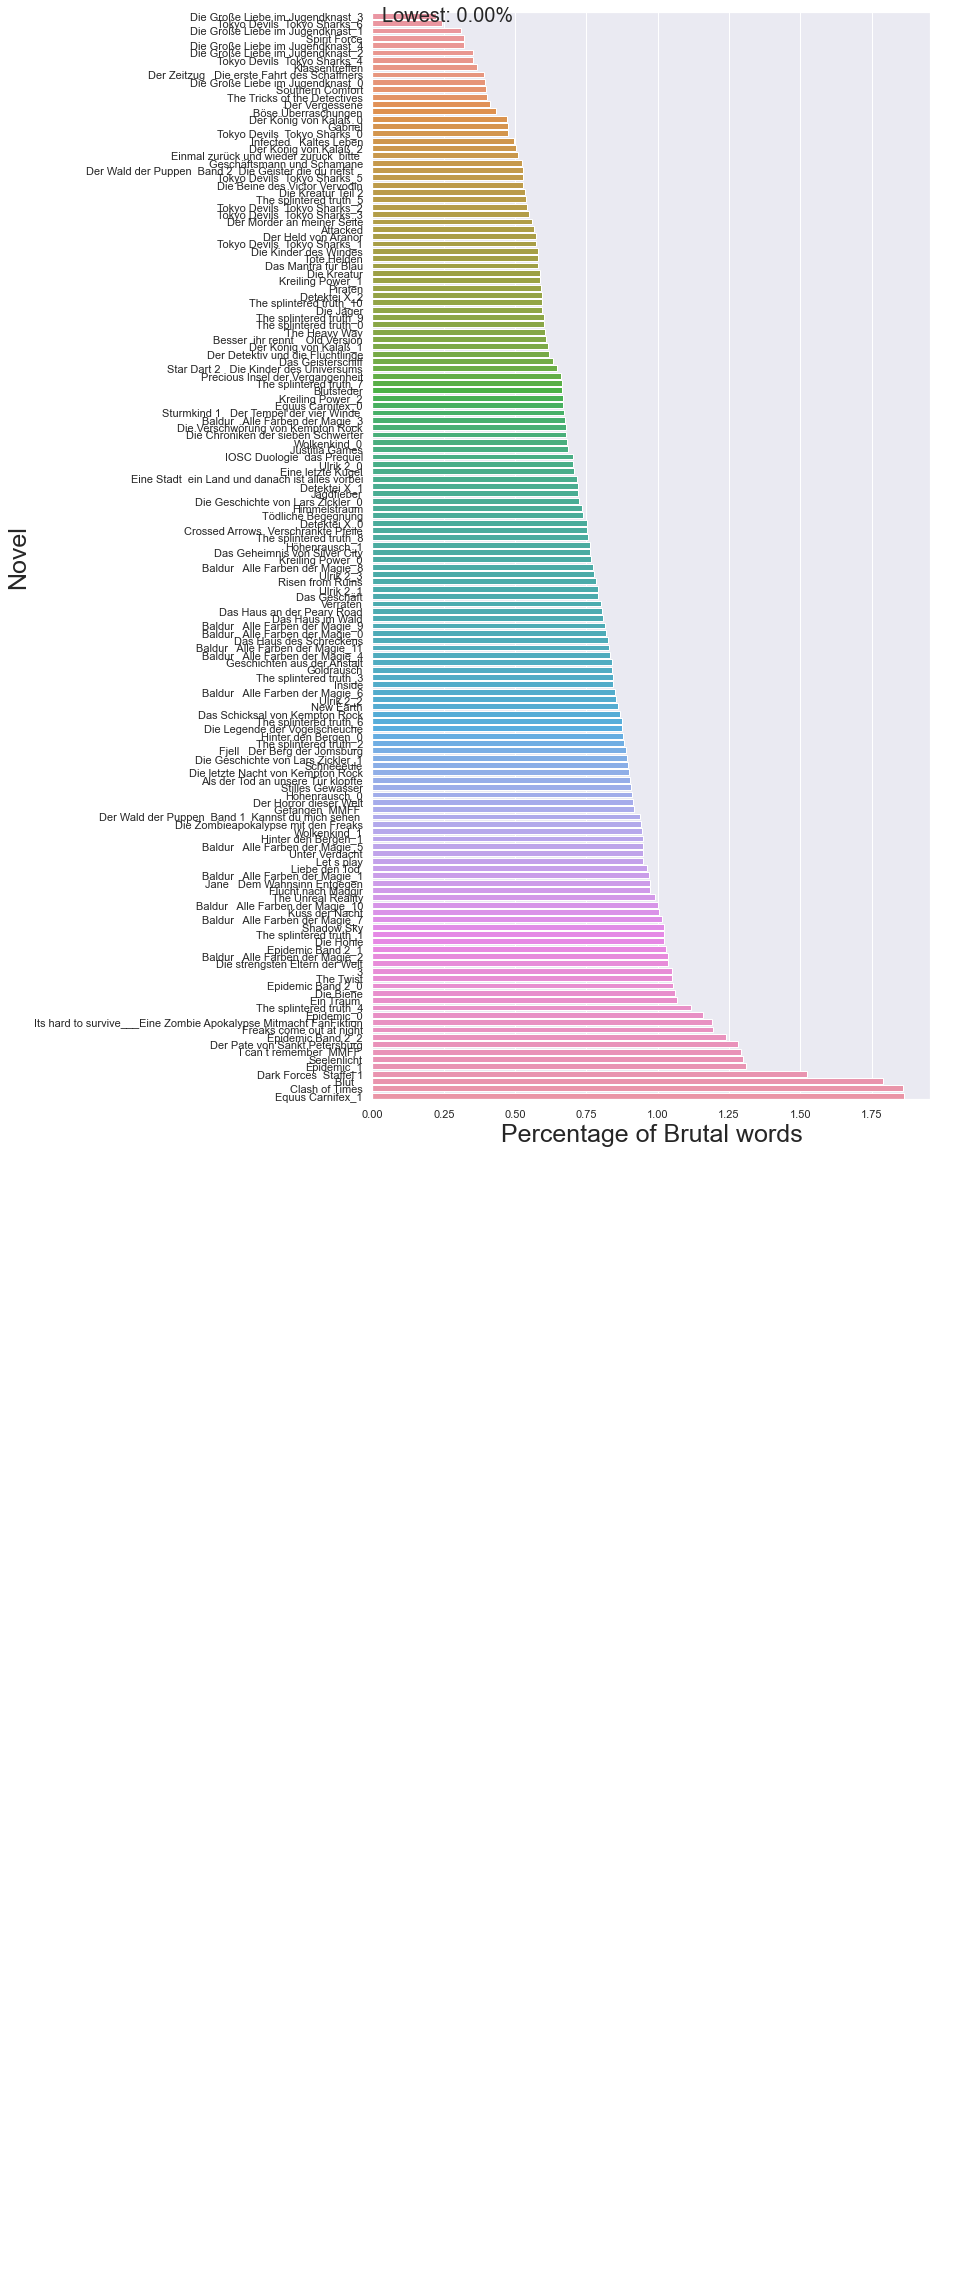

In [46]:
#Die Tabelle von full_W
data_final_full_W = pd.read_csv("finished_data_full_W.csv", sep ="|" )
df_full_W =  data_final_full_W.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 20)})
sns.barplot(x='Percentage', y='novel', data=df_full_M)

plt.xlabel('Percentage of Brutal words', fontsize = 25)
plt.ylabel('Novel', fontsize = 25)

highest_percentage = df_full_W['Percentage'].max()
lowest_percentage = df_full_W['Percentage'].min()
average_percentage = df_full_W['Percentage'].mean()

text_highest = f'Highest: {highest_percentage:.2f}%'
text_lowest = f'Lowest: {lowest_percentage:.2f}%'
text_average = f'Average: {average_percentage:.2f}%'

plt.annotate(text_highest, xy=(highest_percentage, len(df_full_W)-1), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_lowest, xy=(lowest_percentage, 0), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')
plt.annotate(text_average, xy=(average_percentage, len(df_full_W)//2), xytext=(10, 0),
             ha='left', va='center', fontsize=20, xycoords='data', textcoords='offset points')

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

# Comparison plots

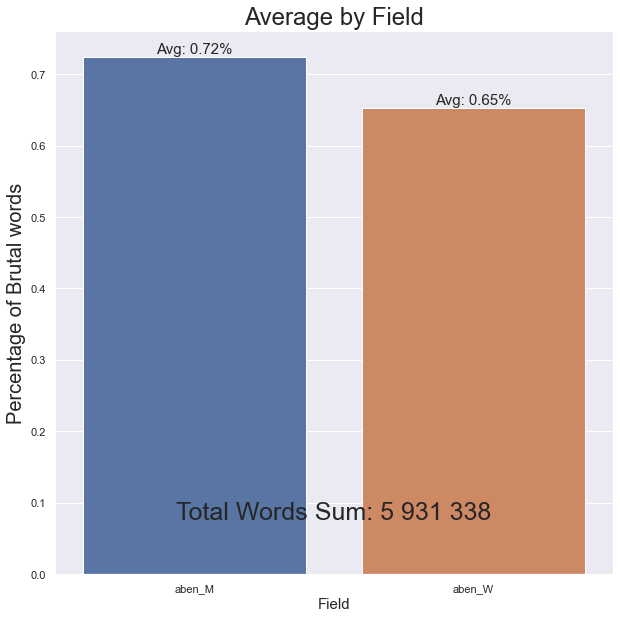

In [47]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.barplot(data=df_aben, x='field', y='Percentage', ci= None)

# Calculate and display average and mean for each group
average_per_group = df_aben.groupby('field')['Percentage'].mean()
total_words_sum = df_aben['Total Words'].sum()

for i, field in enumerate(df_aben['field'].unique()):
    plt.text(i, average_per_group[field], f'Avg: {average_per_group[field]:.2f}%', ha='center', va='bottom', fontsize=15)

plt.xlabel('Field', fontsize=15)
plt.ylabel('Percentage of Brutal words', fontsize=20)
plt.title('Average by Field', fontsize=24)

plt.text(0.5, 0.1, f"Total Words Sum: {'{:,.0f}'.format(total_words_sum).replace(',', ' ')}",
         ha= "center", transform=plt.gca().transAxes, fontsize=25)
    

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

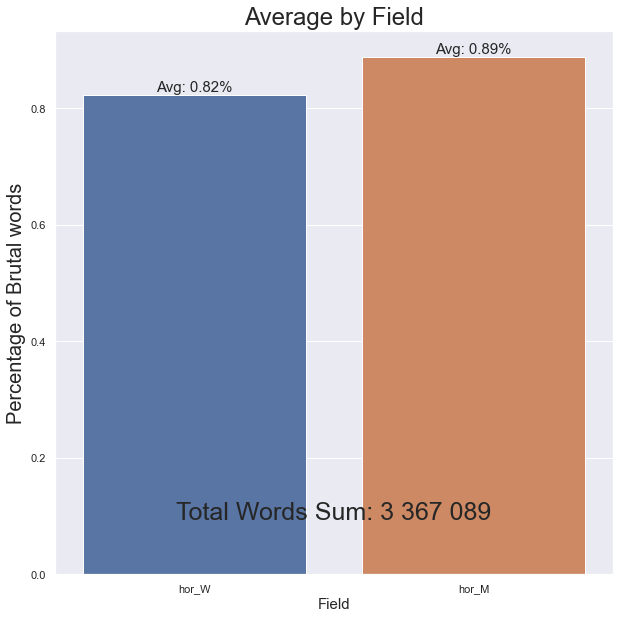

In [48]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.barplot(data=df_hor, x='field', y='Percentage', ci= None)

# Calculate and display average and mean for each group
average_per_group = df_hor.groupby('field')['Percentage'].mean()
total_words_sum = df_hor['Total Words'].sum()

for i, field in enumerate(df_hor['field'].unique()):
    plt.text(i, average_per_group[field], f'Avg: {average_per_group[field]:.2f}%', ha='center', va='bottom', fontsize=15)

plt.xlabel('Field', fontsize=15)
plt.ylabel('Percentage of Brutal words', fontsize=20)
plt.title('Average by Field', fontsize=24)

plt.text(0.5, 0.1, f"Total Words Sum: {'{:,.0f}'.format(total_words_sum).replace(',', ' ')}",
         ha= "center", transform=plt.gca().transAxes, fontsize=25)
    

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

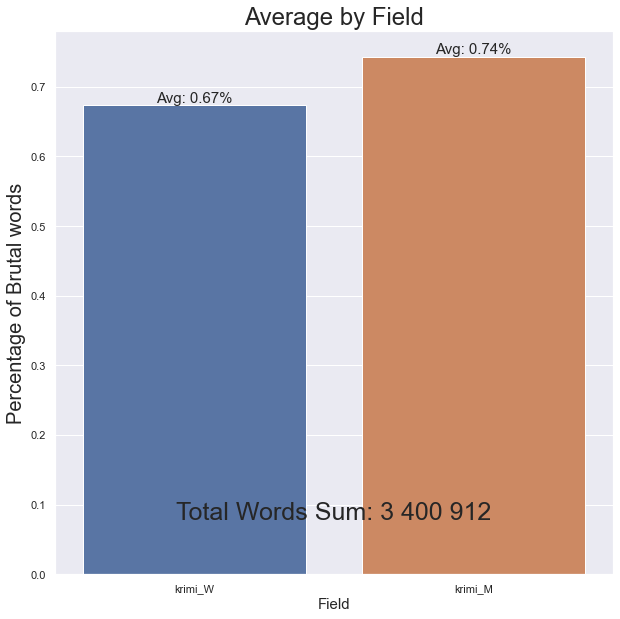

In [49]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.barplot(data=df_krimi, x='field', y='Percentage', ci= None)

# Calculate and display average and mean for each group
average_per_group = df_krimi.groupby('field')['Percentage'].mean()
total_words_sum = df_krimi['Total Words'].sum()

for i, field in enumerate(df_krimi['field'].unique()):
    plt.text(i, average_per_group[field], f'Avg: {average_per_group[field]:.2f}%', ha='center', va='bottom', fontsize=15)

plt.xlabel('Field', fontsize=15)
plt.ylabel('Percentage of Brutal words', fontsize=20)
plt.title('Average by Field', fontsize=24)

plt.text(0.5, 0.1, f"Total Words Sum: {'{:,.0f}'.format(total_words_sum).replace(',', ' ')}",
         ha= "center", transform=plt.gca().transAxes, fontsize=25)
    

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

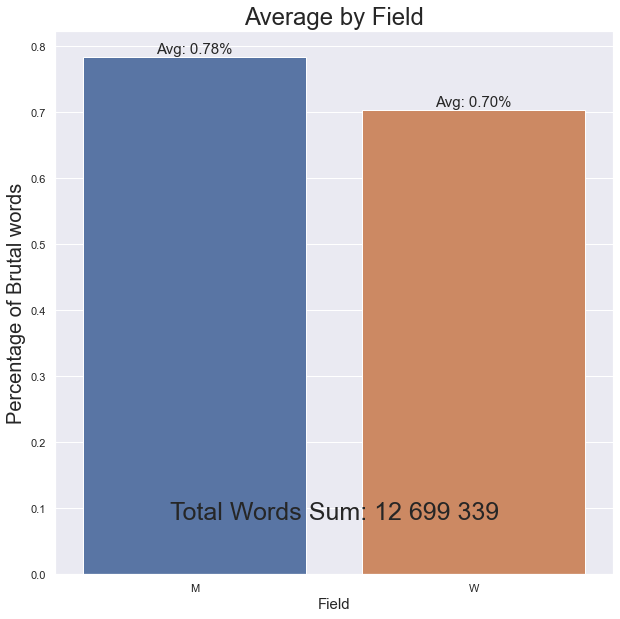

In [50]:
data_final_full = pd.read_csv("csv_analyse_data_full2.csv", sep ="|" )
df_full =  data_final_full.sort_values('Percentage', ascending=True)#DataFrame mit den Anteilen der Adjektive hier einfügen

sns.set(rc={'figure.figsize':(10, 10)})
sns.barplot(data=df_full, x='field', y='Percentage', ci= None)

# Calculate and display average and mean for each group

average_per_group = df_full.groupby('field')['Percentage'].mean()
total_words_sum = df_full['Total Words'].sum()

for i, field in enumerate(df_full['field'].unique()):
    plt.text(i, average_per_group[field], f'Avg: {average_per_group[field]:.2f}%', ha='center', va='bottom', fontsize=15)

plt.xlabel('Field', fontsize=15)
plt.ylabel('Percentage of Brutal words', fontsize=20)
plt.title('Average by Field', fontsize=24)

plt.text(0.5, 0.1, f"Total Words Sum: {'{:,.0f}'.format(total_words_sum).replace(',', ' ')}",
         ha= "center", transform=plt.gca().transAxes, fontsize=25)
    

if SAVE_FILES: plt.savefig(file_path, dpi= 300, bbox_inches ='tight')

plt.show()

# Brut Types

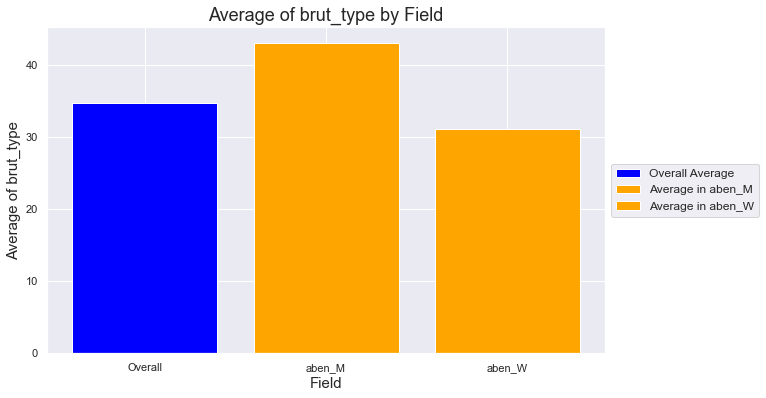

In [51]:
overall_avg_brut_type = df_aben['brut_type'].mean()

# Calculate the average of "brut_type" for each unique group in the 'field' column
avg_brut_type_by_field = df_aben.groupby('field')['brut_type'].mean()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a barplot to display the overall average and averages by field
plt.bar("Overall", overall_avg_brut_type, label='Overall Average', color='blue')
for field, avg in avg_brut_type_by_field.items():
    plt.bar(field, avg, label=f'Average in {field}', color='orange')

plt.xlabel('Field', fontsize=15)
plt.ylabel('Average of brut_type', fontsize=15)
plt.title('Average of brut_type by Field', fontsize=18)
plt.legend(fontsize=12)

plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

# Specify the file path relative to the subdirectory and format (e.g., PNG)
plt.savefig(file_path, dpi=300, bbox_inches='tight')

# To save in other formats, change the file extension (e.g., 'average_brut_type.jpg', 'average_brut_type.pdf')

plt.show()

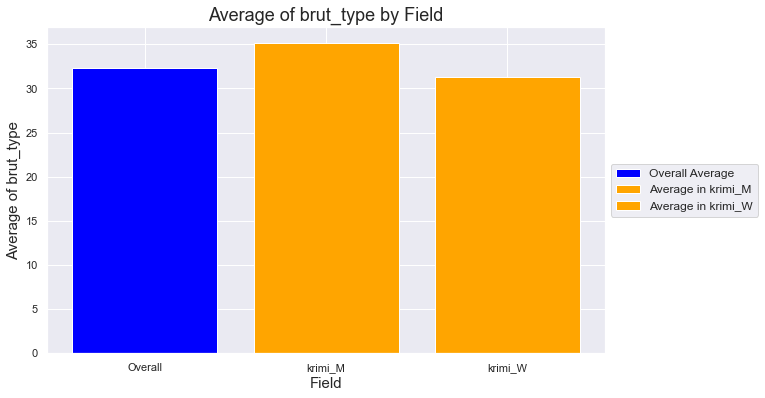

In [52]:
overall_avg_brut_type = df_krimi['brut_type'].mean()

# Calculate the average of "brut_type" for each unique group in the 'field' column
avg_brut_type_by_field = df_krimi.groupby('field')['brut_type'].mean()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a barplot to display the overall average and averages by field
plt.bar("Overall", overall_avg_brut_type, label='Overall Average', color='blue')
for field, avg in avg_brut_type_by_field.items():
    plt.bar(field, avg, label=f'Average in {field}', color='orange')

plt.xlabel('Field', fontsize=15)
plt.ylabel('Average of brut_type', fontsize=15)
plt.title('Average of brut_type by Field', fontsize=18)
plt.legend(fontsize=12)

plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

# Specify the file path relative to the subdirectory and format (e.g., PNG)
plt.savefig(file_path, dpi=300, bbox_inches='tight')

# To save in other formats, change the file extension (e.g., 'average_brut_type.jpg', 'average_brut_type.pdf')

plt.show()

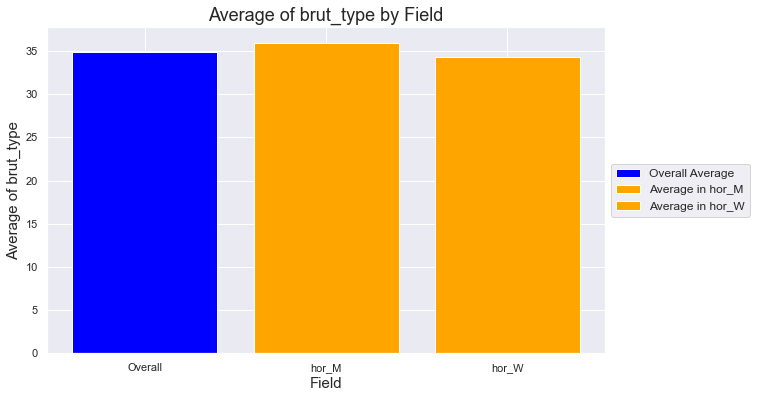

In [53]:
overall_avg_brut_type = df_hor['brut_type'].mean()

# Calculate the average of "brut_type" for each unique group in the 'field' column
avg_brut_type_by_field = df_hor.groupby('field')['brut_type'].mean()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a barplot to display the overall average and averages by field
plt.bar("Overall", overall_avg_brut_type, label='Overall Average', color='blue')
for field, avg in avg_brut_type_by_field.items():
    plt.bar(field, avg, label=f'Average in {field}', color='orange')

plt.xlabel('Field', fontsize=15)
plt.ylabel('Average of brut_type', fontsize=15)
plt.title('Average of brut_type by Field', fontsize=18)
plt.legend(fontsize=12)

plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

# Specify the file path relative to the subdirectory and format (e.g., PNG)
plt.savefig(file_path, dpi=300, bbox_inches='tight')

# To save in other formats, change the file extension (e.g., 'average_brut_type.jpg', 'average_brut_type.pdf')

plt.show()

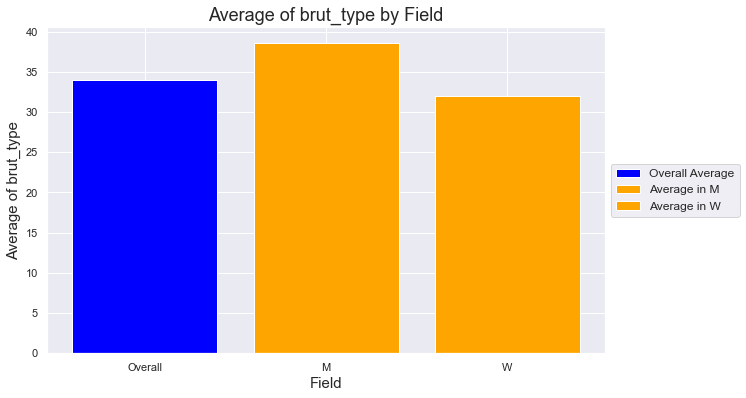

In [54]:
overall_avg_brut_type = df_full['brut_type'].mean()

# Calculate the average of "brut_type" for each unique group in the 'field' column
avg_brut_type_by_field = df_full.groupby('field')['brut_type'].mean()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a barplot to display the overall average and averages by field
plt.bar("Overall", overall_avg_brut_type, label='Overall Average', color='blue')
for field, avg in avg_brut_type_by_field.items():
    plt.bar(field, avg, label=f'Average in {field}', color='orange')

plt.xlabel('Field', fontsize=15)
plt.ylabel('Average of brut_type', fontsize=15)
plt.title('Average of brut_type by Field', fontsize=18)
plt.legend(fontsize=12)

plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

# Specify the file path relative to the subdirectory and format (e.g., PNG)
plt.savefig(file_path, dpi=300, bbox_inches='tight')

# To save in other formats, change the file extension (e.g., 'average_brut_type.jpg', 'average_brut_type.pdf')

plt.show()

In [56]:
#signifikanz bei abenteuer
from scipy import stats

male_data = df_aben[df_aben['field'] == 'aben_M']['Percentage']
female_data = df_aben[df_aben['field'] == 'aben_W']['Percentage']
print(len(male_data))
print(len(female_data))

# Durchführung des T-Tests
alpha = 0.05 
t_statistic, p_value = stats.ttest_ind(male_data, female_data, equal_var=True)
df = len(male_data) + len(female_data) - 2
t_critical = stats.t.ppf(1 - alpha/2, df)

# Ausgabe der Testergebnisse
print(f'df: {df}')
print(f't_critical: {t_critical}')
print(f'T-Statistik: {t_statistic}')
print(f'p-Wert: {p_value}')

# Interpretation der Ergebnisse - P-Wert
print("Ergebnis - p-Wert:")
if p_value < alpha:
    print("Bei Abenteuer: Der Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren ist statistisch signifikant.")
else:
    print("Bei Abenteuer: Es gibt keinen statistisch signifikanten Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren.")

# Interpretation der Ergebnisse: T-Statistik
print("Ergebnis - T-Statistik:")
if t_statistic > t_critical:
    print("Bei Abenteuer: Reject H0")
else:
    print("Bei Abenteuer: don‘t reject H0")


49
114
df: 161
t_critical: 1.974808091744976
T-Statistik: 1.7778831334816219
p-Wert: 0.07731068111696363
Ergebnis - p-Wert:
Bei Abenteuer: Es gibt keinen statistisch signifikanten Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren.
Ergebnis - T-Statistik:
Bei Abenteuer: don‘t reject H0


In [57]:
#signifikanz bei krimi

from scipy import stats

male_data = df_krimi[df_krimi['field'] == 'krimi_M']['Percentage']
female_data = df_krimi[df_krimi['field'] == 'krimi_W']['Percentage']
print(len(male_data))
print(len(female_data))

# Durchführung des T-Tests
alpha = 0.05 
t_statistic, p_value = stats.ttest_ind(male_data, female_data, equal_var=True)
df = len(male_data) + len(female_data) - 2
t_critical = stats.t.ppf(1 - alpha/2, df)

# Ausgabe der Testergebnisse
print(f'T-Statistik: {t_statistic}')
print(f'p-Wert: {p_value}')
print(f'df: {df}')
print(f't_critical: {t_critical}')

# Interpretation der Ergebnisse：P-wert
if p_value < alpha:
    print("Bei Krimi: Der Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren ist statistisch signifikant.")
else:
    print("Bei Krimi: Es gibt keinen statistisch signifikanten Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren.")

# Interpretation der Ergebnisse: T-Statistik
print("Ergebnis - T-Statistik:")
if t_statistic > t_critical:
    print("Bei Krimi: Reject H0")
else:
    print("Bei Krimi: don‘t reject H0")

32
90
T-Statistik: 1.9631704129410246
p-Wert: 0.05193967646503615
df: 120
t_critical: 1.9799304050527766
Bei Krimi: Es gibt keinen statistisch signifikanten Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren.
Ergebnis - T-Statistik:
Bei Krimi: don‘t reject H0


In [58]:
#signifikanz bei horror
from scipy import stats

male_data = df_hor[df_hor['field'] == 'hor_M']['Percentage']
female_data = df_hor[df_hor['field'] == 'hor_W']['Percentage']
print(len(male_data))
print(len(female_data))

# Durchführung des T-Tests
alpha = 0.05 
t_statistic, p_value = stats.ttest_ind(male_data, female_data, equal_var=True)
df = len(male_data) + len(female_data) - 2
t_critical = stats.t.ppf(1 - alpha/2, df)

# Ausgabe der Testergebnisse
print(f'df: {df}')
print(f't_critical: {t_critical}')
print(f'T-Statistik: {t_statistic}')
print(f'p-Wert: {p_value}')

# Interpretation der Ergebnisse：P-wert
if p_value < alpha:
    print("Bei horror: Der Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren ist statistisch signifikant.")
else:
    print("Bei horror: Es gibt keinen statistisch signifikanten Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren.")

# Interpretation der Ergebnisse: T-Statistik
print("Ergebnis - T-Statistik:")
if t_statistic > t_critical:
    print("Bei horror: Reject H0")
else:
    print("Bei horror: don‘t reject H0")

41
72
df: 111
t_critical: 1.9815667570310707
T-Statistik: 1.2518774546793963
p-Wert: 0.21324610124964696
Bei horror: Es gibt keinen statistisch signifikanten Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren.
Ergebnis - T-Statistik:
Bei horror: don‘t reject H0


In [59]:
from scipy import stats

male_data = df_full[df_full['field'] == 'M']['Percentage']
female_data = df_full[df_full['field'] == 'W']['Percentage']
print(len(male_data))
print(len(female_data))

# Durchführung des T-Tests
alpha = 0.05 
t_statistic, p_value = stats.ttest_ind(male_data, female_data, equal_var=True)
df = len(male_data) + len(female_data) - 2
t_critical = stats.t.ppf(1 - alpha/2, df)

# Ausgabe der Testergebnisse
print(f'df: {df}')
print(f't_critical: {t_critical}')
print(f'T-Statistik: {t_statistic}')
print(f'p-Wert: {p_value}')

# Interpretation der Ergebnisse：P-wert
if p_value < alpha:
    print("Bei full: Der Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren ist statistisch signifikant.")
else:
    print("Bei full: Es gibt keinen statistisch signifikanten Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren.")

# Interpretation der Ergebnisse: T-Statistik
print("Ergebnis - T-Statistik:")
if t_statistic > t_critical:
    print("Bei full: Reject H0")
else:
    print("Bei full: don‘t reject H0")

122
276
df: 396
t_critical: 1.9659726084694749
T-Statistik: 3.1022686315692996
p-Wert: 0.002058071123829678
Bei full: Der Unterschied im Anteil der brutalen Worte zwischen männlichen und weiblichen Autoren ist statistisch signifikant.
Ergebnis - T-Statistik:
Bei full: Reject H0
